In [1]:
import numpy as np

import load_mnist
import plot_utils

np.random.seed(1)

/Users/inesalmeida/work/02901_DTU/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Load Data

In [2]:
X_train, y_train = load_mnist.load_train()
X_val, y_val, X_test, y_test = load_mnist.split_val_test(load_mnist.load_test())

Loaded 60000 patterns with 784 features.
Loaded 10000 patterns with 784 features.


### Visualize some examples

In [3]:
%matplotlib inline

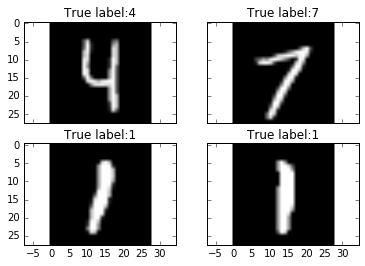

In [4]:
plot_utils.plot_a_few(X_train, y_train)

### Transform Output

In [5]:
from keras.utils import np_utils

Using Theano backend.


In [6]:
NUM_CLASSES = 10

y_train = np_utils.to_categorical(y_train, NUM_CLASSES)
print X_train.shape, y_train.shape
y_val = np_utils.to_categorical(y_val, NUM_CLASSES)
y_test = np_utils.to_categorical(y_test, NUM_CLASSES)

(60000, 784) (60000, 10)


## Part 2: Time Sensitive Optimization
We use a Multilayer Perceptron. We want to estimate the most adequate training hyperparameters in the shortest amount of time.

### Train a Basic Multilayer Perceptron for Illustration

In [7]:
from multilayer_perceptron import build_model

In [8]:
BATCH_SIZE = 10
NUM_EPOCHS = 12

# Build the model (ie the architecture)
model = build_model(num_hidden=32)

# Pick cost function, optimizer, metric
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

# Train
model.fit(X_train, y_train, batch_size=BATCH_SIZE, nb_epoch=NUM_EPOCHS,
          verbose=1, validation_data=(X_val, y_val))

Train on 60000 samples, validate on 2000 samples
Epoch 1/12
60000/60000 [==============================] - 16s - loss: 1.4663 - acc: 0.7250 - val_loss: 0.6553 - val_acc: 0.8460
Epoch 2/12
60000/60000 [==============================] - 17s - loss: 0.9720 - acc: 0.8611 - val_loss: 0.5329 - val_acc: 0.8830
Epoch 3/12
60000/60000 [==============================] - 17s - loss: 0.8724 - acc: 0.8772 - val_loss: 0.4891 - val_acc: 0.8945
Epoch 4/12
60000/60000 [==============================] - 17s - loss: 0.8192 - acc: 0.8868 - val_loss: 0.4759 - val_acc: 0.8960
Epoch 5/12
60000/60000 [==============================] - 17s - loss: 0.7896 - acc: 0.8919 - val_loss: 0.4613 - val_acc: 0.8990
Epoch 6/12
60000/60000 [==============================] - 17s - loss: 0.7672 - acc: 0.8953 - val_loss: 0.4513 - val_acc: 0.9055
Epoch 7/12
60000/60000 [==============================] - 17s - loss: 0.7514 - acc: 0.8995 - val_loss: 0.4455 - val_acc: 0.9065
Epoch 8/12
60000/60000 [==============================]

In [9]:
def score(model, X, y):
    s = model.evaluate(X, y, verbose=0)
    print 'Score:', s[0], 'Accuracy:', s[1]
    
print 'Train',
score(model, X_train, y_train)
print 'Validation',
score(model, X_val, y_val)
print 'Test',
score(model, X_test, y_test)

Train Score: 0.432463565461 Accuracy: 0.909766666667
Validation Score: 0.426930578232 Accuracy: 0.9095
Test Score: 0.431588355899 Accuracy: 0.910375


### The Bayesian Optimization Problem
Following the example in [Snoek, Larochelle and Adams (2012)](https://papers.nips.cc/paper/4522-practical-bayesian-optimization-of-machine-learning-algorithms) for the Logistic Regression model, we want to optimize the following parameters:

* batch size (integer between 20 and 2000)
* L2 regularization parameter (between 0 and 1)
* learning rate (between 0 and 1)
* number of learning epochs (between 5 and 200)
* number of hidden layers (between 16 and 1024)

It is clear some of these parameters affect the time it takes to train the model. With this in mind, we chose to run the Bayesian Optimization taking into consideration the Improvement per Second.

In [10]:
from keras.optimizers import SGD

import GPyOpt

In [11]:
def f(p):
    # p = (l2_coef, learning_rate, num_epochs, batch_size)
    l2_coef = p[0, 0]
    learning_rate = p[0, 1]
    num_epochs = int(p[0, 2])
    batch_size = int(p[0, 3])

    # Build Model
    m = build_model(num_hidden=32, l2_coef=l2_coef)
    
    # Build custom Optimizer
    sgd = SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
    
    # Pick cost function, optimizer, metric
    m.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])
    # Train
    m.fit(X_train, y_train, batch_size=batch_size, nb_epoch=num_epochs,
          verbose=0, validation_data=(X_val, y_val))

    score = m.evaluate(X_test, y_test, verbose=0)
    
    # For progress tracking
    print "l2: {0:.3f},\tlrate: {1:.3f},\tnepoch: {2:d},\tbatch: {3:d}".format(
        l2_coef, learning_rate, num_epochs, batch_size),
    print 'score:', score[0], 'test acc:', score[1]
    
    # Return the score on the test set
    return score[0]

In [12]:
# Define the problem bounds and budget
# Domains:
# l2_coef in [0., 1.]
# learning_rate in { 1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1, 1. }
# num_epochs approximately between 5 and 2000
# batch_size approximately between 20 and 2000

bounds = [{ 'name': 'l2_coef',       'type': 'continuous', 'domain': (0., 1.) },
          { 'name': 'learning_rate', 'type': 'discrete',   'domain': tuple(np.logspace( -6,   0, 7)) },
          { 'name': 'num_epochs',    'type': 'discrete',   'domain': tuple(np.logspace(0.7, 3.3, 5)) },
          { 'name': 'batch_size',    'type': 'discrete',   'domain': tuple(np.logspace(1.3, 3.3, 5)) }]

In [13]:
# Initialize the problem
np.random.seed(123)
myBopt = GPyOpt.methods.BayesianOptimization(f=f, domain=bounds,
                                             #cost_withGradients='evaluation_time',
                                             initial_design_numdata=5,
                                             acquisition_type='EI',
                                             exact_feval = True)

l2: 0.696,	lrate: 0.000,	nepoch: 1995,	batch: 199 score: 1.98403008795 test acc: 0.82075
l2: 0.286,	lrate: 0.100,	nepoch: 1995,	batch: 63 score: 2.05939034414 test acc: 0.444125
l2: 0.227,	lrate: 0.000,	nepoch: 1995,	batch: 1995 score: 1.71773272991 test acc: 0.566625
l2: 0.551,	lrate: 0.000,	nepoch: 22,	batch: 19 score: 1.90566467381 test acc: 0.792125
l2: 0.719,	lrate: 0.001,	nepoch: 446,	batch: 630 score: 1.98853467178 test acc: 0.760375


In [14]:
# Run the optimization
max_iter = 15       # evaluation budget
max_time = 14400    # time budget (4hours)
eps      = 10e-6    # Minimum allows distance between the las two observations

myBopt.run_optimization(max_iter, max_time, eps)  

l2: 0.522,	lrate: 0.010,	nepoch: 1995,	batch: 1995 score: 1.9729374361 test acc: 0.64675
l2: 0.000,	lrate: 0.000,	nepoch: 1995,	batch: 1995 score: 1.88994348145 test acc: 0.42825
l2: 0.228,	lrate: 0.100,	nepoch: 1995,	batch: 1995 score: 2.26908592987 test acc: 0.1515
l2: 0.000,	lrate: 1.000,	nepoch: 22,	batch: 19 score: 14.2866769295 test acc: 0.113625
l2: 0.697,	lrate: 1.000,	nepoch: 1995,	batch: 199 score: nan test acc: 0.097875
l2: 0.466,	lrate: 0.000,	nepoch: 5,	batch: 19 score: 2.10761088943 test acc: 0.207375
l2: 0.466,	lrate: 0.000,	nepoch: 5,	batch: 19 score: 2.17407557535 test acc: 0.2065


In [15]:
# Print the Optimum
print 'x_opt:', myBopt.x_opt
print 'f(x_opt):', myBopt.fx_opt

x_opt: [  6.96534388e-01   1.00000000e+00   1.99526231e+03   1.99526231e+02]
f(x_opt): [ 1.71773273]


In [16]:
# Plot Expected Improvement
myBopt.plot_acquisition()

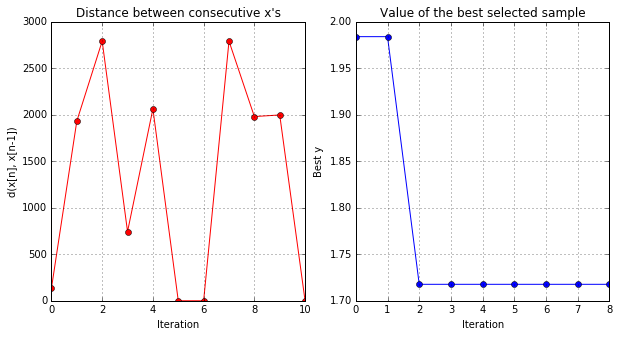

In [17]:
# Convergence
myBopt.plot_convergence()